* survival - 생존유무, target 값. (0 = 사망, 1 = 생존)
* pclass - 티켓 클래스. (1 = 1st, 2 = 2nd, 3 = 3rd)
* sex - 성별
* Age - 나이(세)
* sibsp - 함께 탑승한 형제자매, 배우자 수 총합
* parch - 함께 탑승한 부모, 자녀 수 총합
* ticket - 티켓 넘버
* fare - 탑승 요금
* cabin - 객실 넘버
* bembarked - 탑승 항구

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/Data set/titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/Data set/titanic/test.csv')

In [4]:
submit = pd.read_csv('/content/drive/MyDrive/Kaggle/Data set/titanic/gender_submission.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
# 결측치 확인
print('Train data의 결측치\n\n', train.isnull().sum())
print('Test data의 결측치\n\n', test.isnull().sum())

Train data의 결측치

 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test data의 결측치

 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


# 결측치 처리

In [9]:
train[train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [10]:
train['Age'].replace(np.nan, train['Age'].mean(), inplace=True)
test['Age'].replace(np.nan, test['Age'].mean(), inplace=True)

In [11]:
train.dropna(subset= ['Embarked'], how= 'any',axis=0 ,inplace=True)

In [12]:
train['Cabin'].replace(np.nan, "N", inplace=True)
test['Cabin'].replace(np.nan, "N", inplace=True)

In [13]:
# 앞 대문자 1문자만 따오기
train['Cabin'] = train['Cabin'].str[0]
test['Cabin'] = test['Cabin'].str[0]

In [14]:
print(train.describe())
print(test.describe())

       PassengerId    Survived      Pclass  ...       SibSp       Parch        Fare
count   889.000000  889.000000  889.000000  ...  889.000000  889.000000  889.000000
mean    446.000000    0.382452    2.311586  ...    0.524184    0.382452   32.096681
std     256.998173    0.486260    0.834700  ...    1.103705    0.806761   49.697504
min       1.000000    0.000000    1.000000  ...    0.000000    0.000000    0.000000
25%     224.000000    0.000000    2.000000  ...    0.000000    0.000000    7.895800
50%     446.000000    0.000000    3.000000  ...    0.000000    0.000000   14.454200
75%     668.000000    1.000000    3.000000  ...    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000  ...    8.000000    6.000000  512.329200

[8 rows x 7 columns]
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  418.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.3923

# 이상치

In [15]:
# detect_outlier 함수 정의 

def detect_outlier(df, n, features):
  outlier_indices = []

  # iterate over features(columns)
  for col in features:
    # 1st quartile (25%)
    Q1 = np.percentile(df[col], 25)
    # 3rd quartile (75%)
    Q3 = np.percentile(df[col], 75)
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.5 * IQR

    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    outlier_indices.extend(outlier_list_col)

    
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

  return multiple_outliers

# 이상치 제거하기
Outliers_to_drop = detect_outlier(train, 2, ["Age","SibSp","Parch","Fare"])

In [16]:
# 이상치가 포함된 행 확인하기

train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,N,S
16,17,0,3,"Rice, Master. Eugene",male,2.000000,4,1,382652,29.1250,N,Q
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.000000,4,2,347082,31.2750,N,S
164,165,0,3,"Panula, Master. Eino Viljami",male,1.000000,4,1,3101295,39.6875,N,S
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.000000,0,1,PC 17582,153.4625,C,S
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.000000,1,2,113781,151.5500,C,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.920000,1,2,113781,151.5500,C,S
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.000000,5,2,CA 2144,46.9000,N,S
438,439,0,1,"Fortune, Mr. Mark",male,64.000000,1,4,19950,263.0000,C,S
587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.000000,1,1,13567,79.2000,B,C


In [17]:
# 이상치 제거

train.drop(Outliers_to_drop, axis=0,inplace=True)

# 1. EDA

### 2-1. Pclass
  * Pclass는 카테고리이면서 순서가 있는 데이터타입

In [18]:
# pclass 그룹 별 데이터 카운트

train[["Survived","Pclass"]].groupby(['Pclass']).count()

,Survived
Pclass,
1,203
2,184
3,477


In [19]:
# pclass 그룹 별 생존자수 합

train[['Survived','Pclass']].groupby(['Pclass']).sum()

,Survived
Pclass,
1,128
2,87
3,119


In [20]:
# 위와 같은 작업을 crosstab으로 편하게 할 수 있다.

pd.crosstab(train['Pclass'], train['Survived'], margins=True)

Survived,0,1,All
Pclass,,,
1,75,128,203
2,97,87,184
3,358,119,477
All,530,334,864


In [21]:
# mean은 생존률을 구하게 할 수 있다.

train[['Pclass','Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.630542
2,0.472826
3,0.249476


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

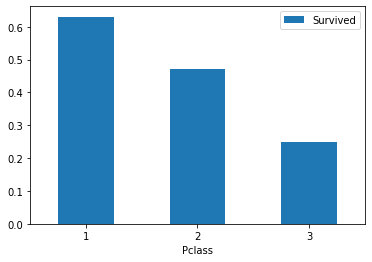

In [22]:
train[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()
plt.xticks(rotation = 360)

-> Pclass가 1일때 즉 티켓의 클래스(1등석, 2등석, 3등석)가 높을수록 생존률이 높다는 것을 알 수 있다.

### 2-2. Sex

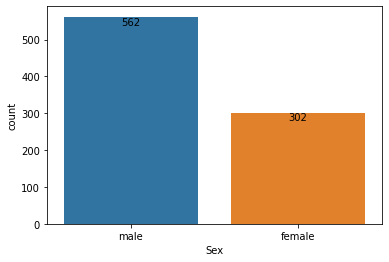

In [23]:
# Sex변수의 분포 확인
g = sns.countplot(train['Sex'])

# 데이터레이블 값 표시를 위한 연산
num = train['Sex'].value_counts()
for i, val in enumerate(num.index):
    g.text(x=i, y=num[i], s=num[i],  horizontalalignment='center',verticalalignment='top')

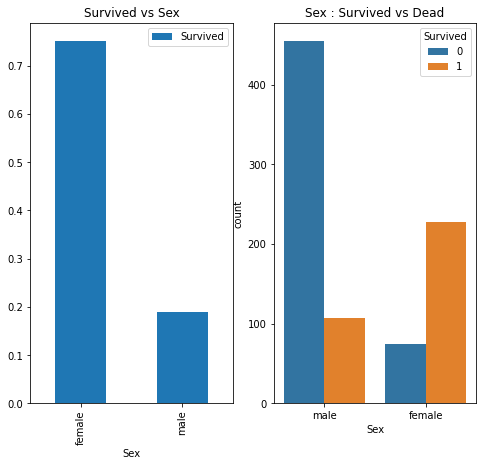

In [24]:
f, ax = plt.subplots(1, 2, figsize=(8,7))

train[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0],
                                                           title="Survived vs Sex")

plt.title('Sex : Survived vs Dead')
sns.countplot(data=train, x='Sex',hue='Survived', ax=ax[1])

-> 성별에 따른 생존률에 대한 그래프를 확인해본 결과 여성의 생존률이 남성보다 높았고, Pclass와 마찬가지로 유의한 결과를 보였다.

### 2-3 Both Sex and Pclass
  * Sex, Pclass 두가지에 관하여 생존이 어떻게 달라지는지 확인해보자.

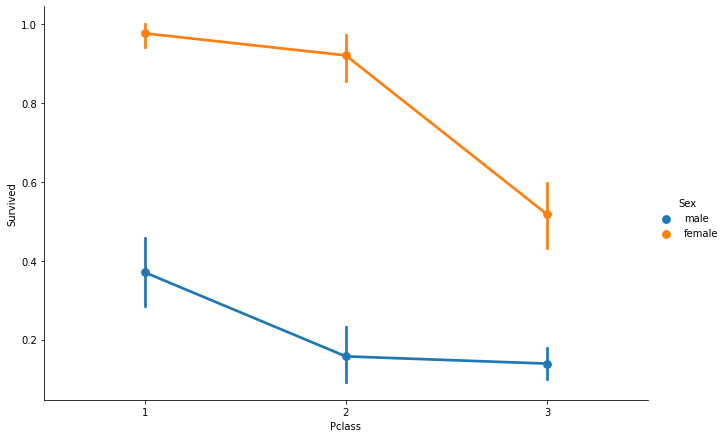

In [25]:
sns.factorplot('Pclass', 'Survived', hue='Sex',data = train, size=6, aspect=1.5)

-> 모든 티켓 클래스에서 여성의 생존확률이 높게 나타났음을 알 수 있다.

### 2-4 Age

In [26]:
# Age 변수의 기술통계값 확인
round(train['Age'].describe(),2)

count    864.00
mean      29.75
std       12.56
min        0.42
25%       22.00
50%       29.70
75%       35.00
max       80.00
Name: Age, dtype: float64

-> Age변수의 평균은 29.75, 중앙값은 29.70, 최소값 0.42, 최대값 80

Text(0.5, 1.0, 'Boxplot of Age')

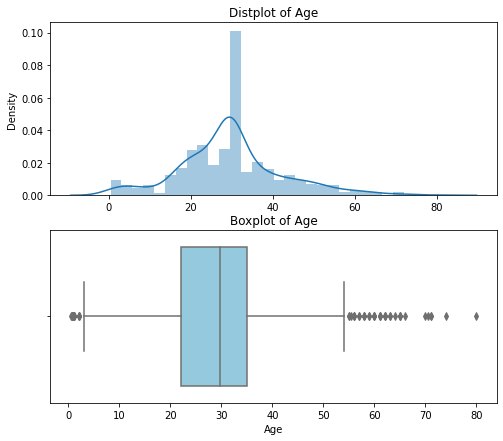

In [27]:
f, ax = plt.subplots(2,1, figsize=(8,7))

sns.distplot(x=train['Age'], ax=ax[0])
ax[0].set_title("Distplot of Age")

sns.boxplot(train['Age'],color="skyblue", ax=ax[1])
ax[1].set_title('Boxplot of Age')

-> 연령대는 대체로 20대와 40대 사이가 많고, 30대가 가장 높게 나타난 것을 알 수 있으며 대체로 정규분포를 따른다고 볼 수 있다.

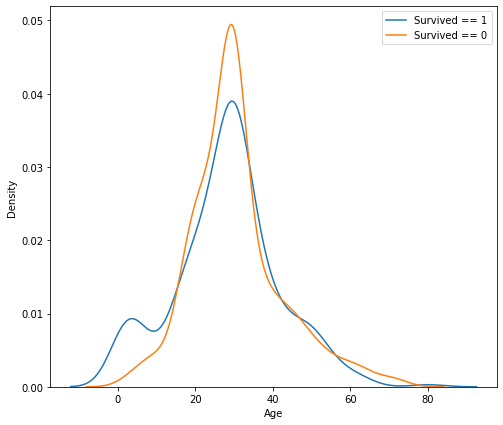

In [28]:
f, ax = plt.subplots(1,1, figsize=(8,7))
sns.kdeplot(train[train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(train[train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1','Survived == 0'])

-> 연령에 따른 생존여부를 확인해본 결과 앞에서 확인한 결과와 마찬가지로 30대에서 생존과 사망 모두 높게 나타났다. 이는 30대의 데이터가 많기 때문으로 판단되고, 어린나이(약 15세 미만) 구간에서 생존률이 상대적으로 높게 나타난 것을 알 수 있다.

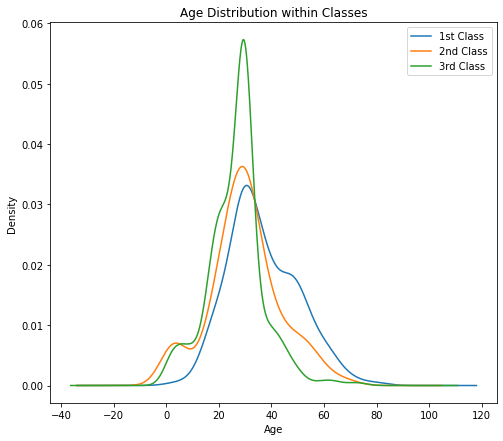

In [29]:
# 티켓 클래스에 따른 Age변수의 분포 시각화
plt.figure(figsize=(8,7))
train['Age'][train['Pclass'] == 1].plot(kind = 'kde')
train['Age'][train['Pclass'] == 2].plot(kind = 'kde')
train['Age'][train['Pclass'] == 3].plot(kind = 'kde')

plt.xlabel('Age')
plt.title("Age Distribution within Classes")
plt.legend(['1st Class','2nd Class','3rd Class'])

->

Text(0.5, 1.02, 'Survived rate change depending on range of Age')

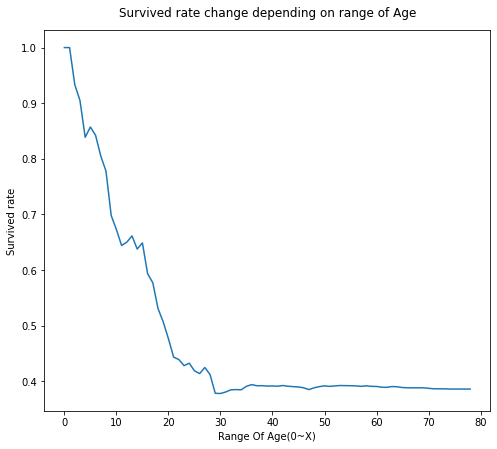

In [30]:
# 나이대가 높아질 수록 생존확률이 어떻게 달라지는지 알고 싶어 누적 확률을 활용한 시각화

cummulate_survival_ratio = []
for i in range(1, 80):
  cummulate_survival_ratio.append(train[train['Age'] < i]['Survived'].sum() / len(train[train['Age'] < i]['Survived']))
  
plt.figure(figsize=(8,7))
plt.plot(cummulate_survival_ratio)
plt.xlabel('Range Of Age(0~X)')
plt.ylabel('Survived rate')
plt.title('Survived rate change depending on range of Age', y=1.02)

-> 나이가 어릴수록 생존률이 확실히 높은것을 확인할 수 있었다. 이를 통해 나이도 중요한 피처임을 알 수 있다.

* 종합하자면 여자이거나 나이가 어리고, 클래스가 높을 수록 생존 확률이 높은 것을 알 수 있다.

### 2.5 Embarked
-> 탑승한 항구를 나타내는 변수

In [31]:
print("<Embarked 변수의 개별값> \n",train['Embarked'].unique())
print("\n<Embarked 변수의 개수> \n",train['Embarked'].value_counts())

<Embarked 변수의 개별값> 
 ['S' 'C' 'Q']

<Embarked 변수의 개수> 
 S    623
C    165
Q     76
Name: Embarked, dtype: int64


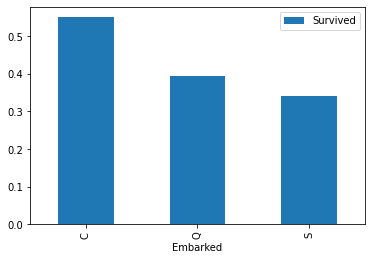

In [41]:
train[['Embarked','Survived']].groupby(['Embarked']).mean().sort_values(by='Survived', ascending=False).plot.bar()

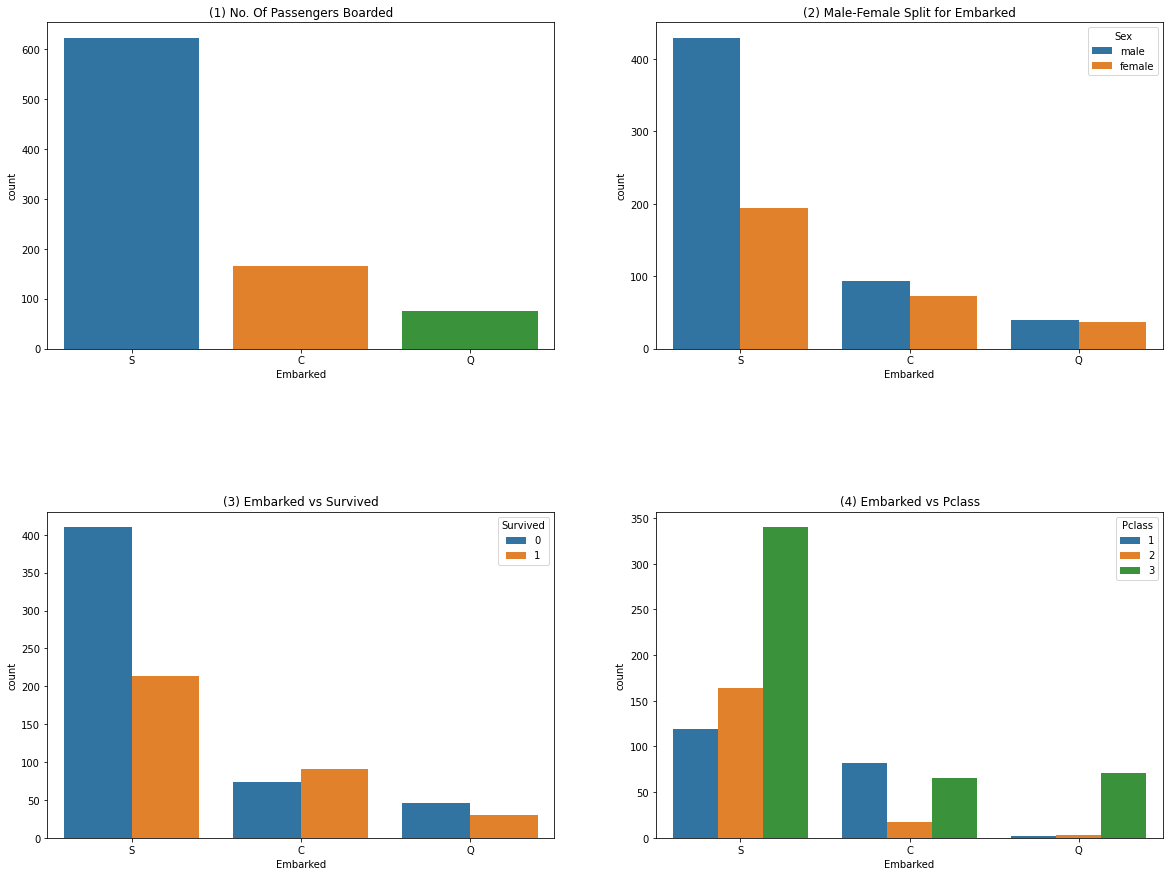

In [44]:
f,ax=plt.subplots(2, 2, figsize=(20,15))
sns.countplot('Embarked', data=train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
sns.countplot('Embarked', hue='Sex', data=train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()